# ЗАНЯТИЕ 2.7. БУСТИНГ. ОБЗОР БИБЛИОТЕКИ XGBOOST

Загружаем библиотеки

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#устраним ошибки со шрифтами
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

## Описание задачи

Используем данные страхового подразделения BNP Paribas из соревнования

https://www.kaggle.com/c/bnp-paribas-cardif-claims-management

Решается задача классификации страховых случаев:
    1. Случаи, требующие дополнительных документов для подтвердения (0)
    2. Случаи, которые можно подтверждать автоматически на основе имеющейся информации (1)

## Загрузка данных

In [3]:
data = pd.read_csv('train.csv')

Уменьшим размер данных для ускорения обучения, возмем случайную подвыборку 20% данных со стратификацией

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

random_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=777)

for train_index, test_index in random_splitter.split(data, data.target):
    data = data.iloc[test_index]

In [6]:
data.shape

(22865, 133)

Разбиение на обучение и hold-out тест 70/30. Данных достаточно много, поэтому можно принебречь честной кросс-валидацией и оценивать модель на тесте

In [7]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=777)

for train_index, test_index in splitter.split(data, data.target):
    d_train = data.iloc[train_index]
    d_test = data.iloc[test_index]
    
    y_train = data['target'].iloc[train_index]
    y_test = data['target'].iloc[test_index]

## Первичный анализ

Размер датасета

In [8]:
data.shape

(22865, 133)

Распределение значений таргета (event rate)

In [9]:
data.target.value_counts() / len(data)

1    0.761207
0    0.238793
Name: target, dtype: float64

## Предобработка данных

Находим категориальные признаки

Чтобы в разы не увеличивать число признаков при построении dummy, будем использовать категориальные признаки с < 30 уникальных значений

In [10]:
cat_feat = list(data.dtypes[data.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'target'])]

cat_nunique = d_train[cat_feat].nunique()
print(cat_nunique)
cat_feat = list(cat_nunique[cat_nunique < 30].index)

v3         3
v22     6610
v24        5
v30        7
v31        3
v47        9
v52       12
v56       90
v66        3
v71        5
v74        3
v75        4
v79       17
v91        7
v107       7
v110       3
v112      22
v113      34
v125      88
dtype: int64


In [11]:
from sklearn.metrics import auc, roc_curve

**Создаем признаки для "деревянных" моделей**

1. Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
3. Создаем дамми-переменные для категорий

In [12]:
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


X_train = pd.concat([d_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

**Добавляем средние значения таргета внутри всех категориальных признаков по фолдам, через стекинг**

In [13]:
class MeanClassifier():
    def __init__(self, col):
        self._col = col
        
    def fit(self, X, y):
        self._y_mean = y.mean()
        self._means = y.groupby(X[self._col].astype(str)).mean()

    def predict_proba(self, X):
        new_feature = X[self._col].astype(str)\
            .map(self._means.to_dict())\
            .fillna(self._y_mean)
        return np.stack([1-new_feature, new_feature], axis=1)
    
    
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict_proba(X_train.iloc[test_ind])[:, 1]
        meta_test += clf.predict_proba(X_test)[:, 1]
    
    return meta_train, meta_test / stack_cv.n_splits


from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=10, random_state=555)

meta_train = []
meta_test = []
col_names = []

for c in tqdm.tqdm(cat_nunique.index.tolist()):
    clf = MeanClassifier(c)
    
    meta_tr, meta_te = get_meta_features(clf, d_train, y_train, d_test, stack_cv)

    meta_train.append(meta_tr)
    meta_test.append(meta_te)
    col_names.append('mean_pred_{}'.format(c))

X_mean_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names, index=d_train.index)
X_mean_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names, index=d_test.index)

X_train = pd.concat([X_train, X_mean_train], axis=1)
X_test = pd.concat([X_test, X_mean_test], axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.34it/s]


#### Считаем ROC AUC

In [14]:
def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

## Обучение моделей

### Случайный лес

Предсказываем вероятность класса 1 и считаем ROC AUC

In [28]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=50, max_depth=15, min_samples_leaf=20, max_features=0.8, n_jobs=-1)

clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Train:
ROC AUC: 0.9117
Test:
ROC AUC: 0.7304


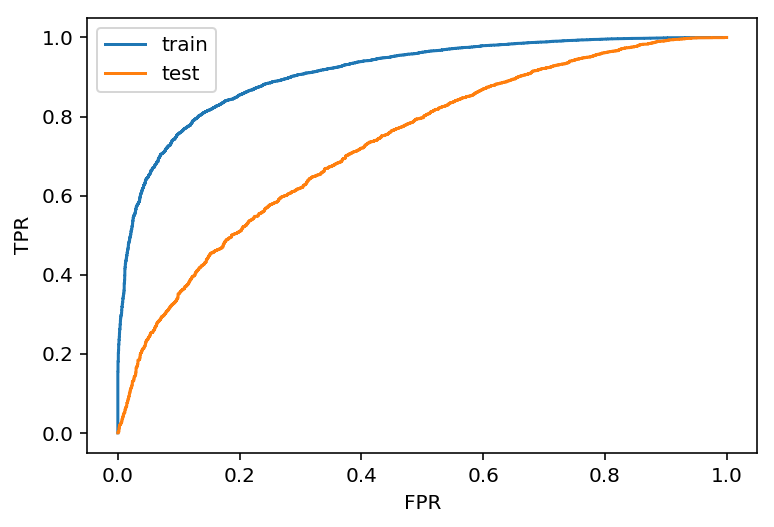

In [29]:
y_pred_rf_test = clf_rf.predict_proba(X_test)[:, 1]
y_pred_rf_train = clf_rf.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_rf_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_rf_test, 'test')
plt.legend();

### Бустинг в sklearn

In [122]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

Adaboost

Train:
ROC AUC: 0.7974
Test:
ROC AUC: 0.7254


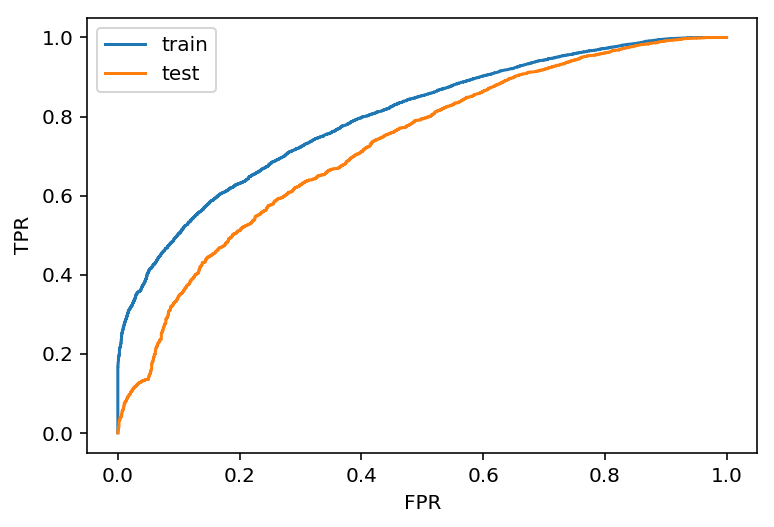

In [158]:
clf_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, max_features=0.8),
                             n_estimators=20, learning_rate=0.1)

clf_ada.fit(X_train, y_train)
y_pred_ada_test = clf_ada.predict_proba(X_test)[:, 1]
y_pred_ada_train = clf_ada.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_ada_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_ada_test, 'test')
plt.legend();

GradientBoosting

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.0765           0.0217            5.23s
         2           1.0587           0.0182            5.15s
         3           1.0376           0.0163            4.90s
         4           1.0249           0.0114            4.59s
         5           1.0076           0.0105            4.31s
         6           0.9968           0.0088            3.97s
         7           0.9792           0.0059            3.71s
         8           0.9753           0.0060            3.43s
         9           0.9734           0.0033            3.13s
        10           0.9668           0.0029            2.86s
        11           0.9596           0.0033            2.64s
        12           0.9492           0.0021            2.33s
        13           0.9441           0.0023            2.03s
        14           0.9511           0.0017            1.75s
        15           0.9423           0.0025            1.45s
       

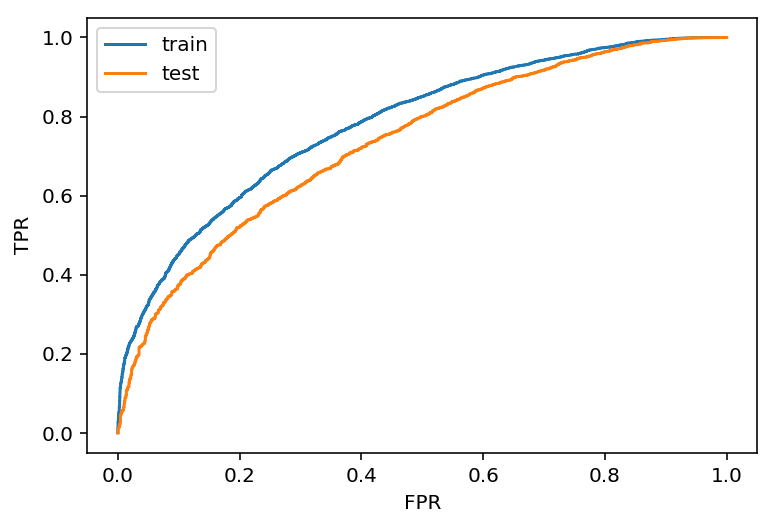

In [157]:
clf_gbm = GradientBoostingClassifier(max_depth=5, min_samples_leaf=20, n_estimators=20, learning_rate=0.1, 
                                     subsample=0.8, max_features=0.8, verbose=2)

clf_gbm.fit(X_train, y_train)
y_pred_gbm_test = clf_gbm.predict_proba(X_test)[:, 1]
y_pred_gbm_train = clf_gbm.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_gbm_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_gbm_test, 'test')
plt.legend();

### XGBOOST

In [31]:
import xgboost as xgb

**Важные гиперпараметры алгоритма**

a. Параметры деревьев
    1. max_depth - максимальная глубина дерева (обычно 3-10, больше глубина -> больше риск переобучения)
    2. min_child_weight - минимальное число объектов в листе (обычно до 20, больше объектов -> меньше риск переобучения, но должен быть согласован с глубиной дерева)
    3. gamma - минимально необходимый прирост качества для разбиения листа (редко используется)

b. Параметры бустинга
    0. objective - оптимизируемый функционал (встроен для классификации и регрессии, можно написать свой дифференцируемый)
    1. n_estimators - кол-во базовых алгоритмов (чем меньше learning_rate, тем больше деревьев)
    2. learning_rate - шаг создания ансамбля (зависит от n_estimators, но обычно 0.01 - 0.1)
    2. colsample_bytree - доля признаков, случайно выбирающихся для построения дерева
    3. subsample - доля объектов, случайно выбирающихся для построения дерева
    4. n_jobs - кол-во потоков для одновременного построения деревьев (большая прибавка к скорости на многоядерных процах)
    5. reg_alpha - вес L1 регуляризации (редко используется)
    6. reg_lambda - вес L2 регуляризации (редко используется)

Параметры по умолчанию

In [134]:
params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1,
          'n_jobs': 4}

clf_xgb = xgb.XGBClassifier(**params)
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=5, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Train:
ROC AUC: 0.7835
Test:
ROC AUC: 0.7354


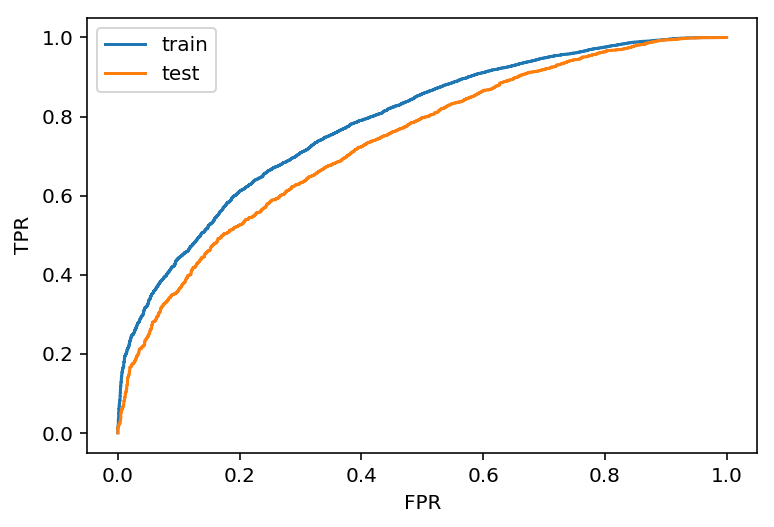

In [34]:
y_pred_xgb_test = clf_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_train = clf_xgb.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_xgb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_xgb_test, 'test')
plt.legend();

#### Онлайн оценка качества 

Во время обучения можно следить за качеством во время каждой итерации

Для этого используются параметры:
    1. eval_metric - метрика 'auc', 'rmse', 'logloss', ...
    2. eval_set - список выборок вида [(X, y), ...] на которых тестировать алгоритм

In [35]:
params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1,
          'n_jobs': 4}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.705711	validation_1-auc:0.698949
[1]	validation_0-auc:0.708731	validation_1-auc:0.701512
[2]	validation_0-auc:0.709658	validation_1-auc:0.699875
[3]	validation_0-auc:0.713969	validation_1-auc:0.705119
[4]	validation_0-auc:0.718416	validation_1-auc:0.711885
[5]	validation_0-auc:0.719184	validation_1-auc:0.713378
[6]	validation_0-auc:0.723563	validation_1-auc:0.716415
[7]	validation_0-auc:0.724939	validation_1-auc:0.7178
[8]	validation_0-auc:0.728176	validation_1-auc:0.721416
[9]	validation_0-auc:0.729732	validation_1-auc:0.722481
[10]	validation_0-auc:0.731069	validation_1-auc:0.724036
[11]	validation_0-auc:0.731379	validation_1-auc:0.724257
[12]	validation_0-auc:0.731565	validation_1-auc:0.723903
[13]	validation_0-auc:0.732835	validation_1-auc:0.725882
[14]	validation_0-auc:0.732879	validation_1-auc:0.725618
[15]	validation_0-auc:0.73422	validation_1-auc:0.726499
[16]	validation_0-auc:0.735358	validation_1-auc:0.727529
[17]	validation_0-auc:0.73582	validation_1-a

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

### Самостоятельное задание

Сравнить алгоритмы AdaBoost, GradientBoostingClassifier и Xgboost с похожим набором параметров

In [149]:
### TODO













### TODO

Возмем параметры, с которых лучше всего начать

In [38]:
params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_jobs': 4}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.703531	validation_1-auc:0.682839
[1]	validation_0-auc:0.74384	validation_1-auc:0.722836
[2]	validation_0-auc:0.75044	validation_1-auc:0.728854
[3]	validation_0-auc:0.753192	validation_1-auc:0.729696
[4]	validation_0-auc:0.757253	validation_1-auc:0.730688
[5]	validation_0-auc:0.75955	validation_1-auc:0.731657
[6]	validation_0-auc:0.76186	validation_1-auc:0.732648
[7]	validation_0-auc:0.763777	validation_1-auc:0.733129
[8]	validation_0-auc:0.765428	validation_1-auc:0.733163
[9]	validation_0-auc:0.766735	validation_1-auc:0.73366
[10]	validation_0-auc:0.768941	validation_1-auc:0.734417
[11]	validation_0-auc:0.770827	validation_1-auc:0.734736
[12]	validation_0-auc:0.772073	validation_1-auc:0.735026
[13]	validation_0-auc:0.774177	validation_1-auc:0.735319
[14]	validation_0-auc:0.775407	validation_1-auc:0.736038
[15]	validation_0-auc:0.777063	validation_1-auc:0.735768
[16]	validation_0-auc:0.779128	validation_1-auc:0.735215
[17]	validation_0-auc:0.781211	validation_1-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

Достанем из объекта clf_xgb списки результатов метрик по итерациям, построим графики

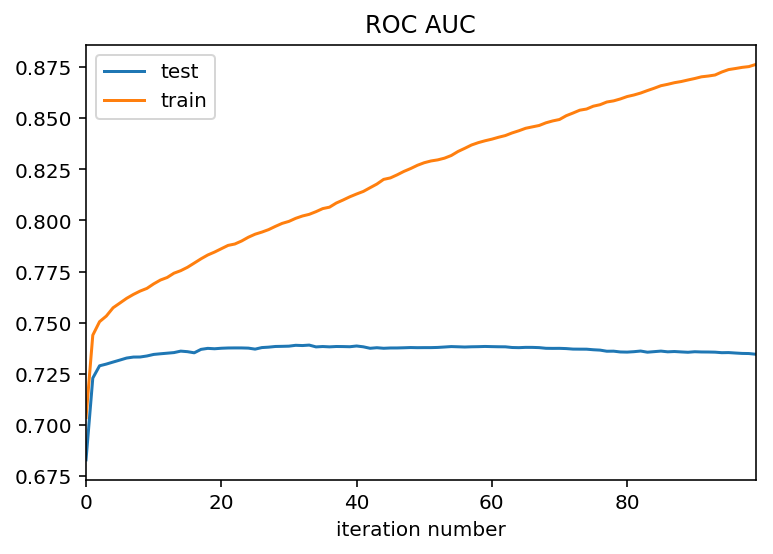

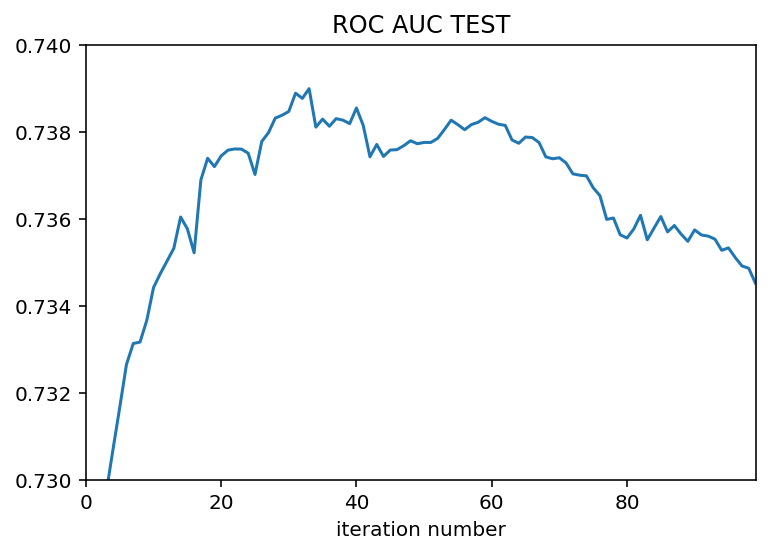

In [39]:
def save_online_metric(clf):
    return pd.DataFrame({'train': clf.evals_result()['validation_0']['auc'],
                         'test': clf.evals_result()['validation_1']['auc']})
res = save_online_metric(clf_xgb)
res.plot(title='ROC AUC')
plt.xlabel('iteration number')
plt.figure()
res.test.plot(ylim=(0.73, 0.74), title='ROC AUC TEST')
plt.xlabel('iteration number')

Нужно побороть переобучение, уменьшим learning_rate. Также уменьшим кол-во деревьев для ускорения обучения

In [40]:
params = {'n_estimators': 50,
          'learning_rate': 0.03,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_jobs': 4}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

best_params = params

[0]	validation_0-auc:0.703531	validation_1-auc:0.682839
[1]	validation_0-auc:0.740659	validation_1-auc:0.720849
[2]	validation_0-auc:0.748183	validation_1-auc:0.727118
[3]	validation_0-auc:0.749137	validation_1-auc:0.727586
[4]	validation_0-auc:0.753917	validation_1-auc:0.728769
[5]	validation_0-auc:0.75514	validation_1-auc:0.730217
[6]	validation_0-auc:0.755738	validation_1-auc:0.730652
[7]	validation_0-auc:0.756763	validation_1-auc:0.730646
[8]	validation_0-auc:0.758972	validation_1-auc:0.73104
[9]	validation_0-auc:0.759309	validation_1-auc:0.731153
[10]	validation_0-auc:0.760267	validation_1-auc:0.732043
[11]	validation_0-auc:0.761296	validation_1-auc:0.732428
[12]	validation_0-auc:0.761979	validation_1-auc:0.732936
[13]	validation_0-auc:0.764167	validation_1-auc:0.733775
[14]	validation_0-auc:0.764621	validation_1-auc:0.734289
[15]	validation_0-auc:0.765574	validation_1-auc:0.734629
[16]	validation_0-auc:0.766147	validation_1-auc:0.734506
[17]	validation_0-auc:0.76673	validation_1-

### Перебор параметров по сетке

Опишем функцию, похожую на GridSearchCV, только для одной отложенной выборки X_test. Она перебирает параметки по заданной сетке и возврашает лучшие по ROC AUC

In [41]:
def find_params(clf, param_grid):
    clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=[(np.arange(len(X_train)),
                                                               np.arange(len(X_test)) + len(X_train))],
                  verbose=3)

    clf.fit(pd.concat([X_train, X_test]).values, pd.concat([y_train, y_test]).values)
    best_params = clf.best_estimator_.get_params()
    print('Best test ROC AUC: ', clf.best_score_)
    print('Best params: ', best_params)
    return best_params

**Процесс подбора параметров**:

1. Зафиксируем learning_rate и n_estimators, чтобы модель не переобучалась во время итераций
2. Настраиваем параметры деревьев: max_depth и min_child_weight
3. Настраиваем gamma (опционально)
4. Настраиваем subsample и colsample_bytree
5. Настраиваем регуляризацию reg_lambda и reg_alpha
6. Уменьшаем learning_rate, увеличиваем кол-во деревьев и обучаем заново на лучших параметрах

#### Подбираем max_depth и min_child_weight

In [170]:
from sklearn.model_selection import GridSearchCV

clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'max_depth': [3, 5, 10],
    'min_child_weight': [10, 20, 100]#[1, 5, 10]
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] max_depth=3, min_child_weight=10 ................................
[CV]  max_depth=3, min_child_weight=10, score=0.7297723447665999, total=   6.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s


[CV] max_depth=3, min_child_weight=20 ................................
[CV]  max_depth=3, min_child_weight=20, score=0.7296626837990299, total=   7.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.3s remaining:    0.0s


[CV] max_depth=3, min_child_weight=100 ...............................
[CV]  max_depth=3, min_child_weight=100, score=0.7282958966222084, total=   9.5s
[CV] max_depth=5, min_child_weight=10 ................................
[CV]  max_depth=5, min_child_weight=10, score=0.7375936385415512, total=  12.2s
[CV] max_depth=5, min_child_weight=20 ................................
[CV]  max_depth=5, min_child_weight=20, score=0.7374893554039476, total=  10.9s
[CV] max_depth=5, min_child_weight=100 ...............................
[CV]  max_depth=5, min_child_weight=100, score=0.7341031930748515, total=  10.3s
[CV] max_depth=10, min_child_weight=10 ...............................
[CV]  max_depth=10, min_child_weight=10, score=0.7357403331168173, total=  24.2s
[CV] max_depth=10, min_child_weight=20 ...............................
[CV]  max_depth=10, min_child_weight=20, score=0.737576335958182, total=  20.3s
[CV] max_depth=10, min_child_weight=100 ..............................
[CV]  max_depth=10, 

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.0min finished


Best test ROC AUC:  0.737593638542
Best params:  {'booster': 'gbtree', 'learning_rate': 0.03, 'reg_lambda': 1, 'colsample_bytree': 0.8, 'subsample': 0.8, 'silent': True, 'colsample_bylevel': 1, 'nthread': None, 'n_jobs': -1, 'max_delta_step': 0, 'gamma': 0, 'seed': None, 'n_estimators': 50, 'min_child_weight': 10, 'reg_alpha': 0, 'scale_pos_weight': 1, 'max_depth': 5, 'objective': 'binary:logistic', 'base_score': 0.5, 'missing': None, 'random_state': 0}


#### Подбираем gamma

In [140]:
clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'gamma': np.linspace(0, 0.5, 5)
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV] gamma=0.0 .......................................................
[CV] .............. gamma=0.0, score=0.7375936385415512, total=  10.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.7s remaining:    0.0s


[CV] gamma=0.125 .....................................................
[CV] ............. gamma=0.125, score=0.737569789034745, total=  10.5s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.4s remaining:    0.0s


[CV] gamma=0.25 ......................................................
[CV] ............. gamma=0.25, score=0.7376232166063648, total=  10.5s
[CV] gamma=0.375 .....................................................
[CV] ............ gamma=0.375, score=0.7375939892695924, total=  10.4s
[CV] gamma=0.5 .......................................................
[CV] .............. gamma=0.5, score=0.7375813630601069, total=  10.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.0s finished


Best test ROC AUC:  0.737623216606
Best params:  {'booster': 'gbtree', 'learning_rate': 0.03, 'reg_lambda': 1, 'colsample_bytree': 0.8, 'subsample': 0.8, 'silent': True, 'colsample_bylevel': 1, 'nthread': None, 'n_jobs': -1, 'max_delta_step': 0, 'gamma': 0.25, 'seed': None, 'n_estimators': 50, 'min_child_weight': 10, 'reg_alpha': 0, 'scale_pos_weight': 1, 'max_depth': 5, 'objective': 'binary:logistic', 'base_score': 0.5, 'missing': None, 'random_state': 0}


#### Подбираем subsample и colsample_bytree

In [147]:
clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'subsample': np.linspace(0.5, 1, 6),
    'colsample_bytree': np.linspace(0.5, 1, 6)
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
[CV] subsample=0.5, colsample_bytree=0.5 .............................
[CV]  subsample=0.5, colsample_bytree=0.5, score=0.735011929429777, total=   7.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s


[CV] subsample=0.6, colsample_bytree=0.5 .............................
[CV]  subsample=0.6, colsample_bytree=0.5, score=0.734397629265496, total=   7.8s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.6s remaining:    0.0s


[CV] subsample=0.7, colsample_bytree=0.5 .............................
[CV]  subsample=0.7, colsample_bytree=0.5, score=0.7375817722428217, total=   7.6s
[CV] subsample=0.8, colsample_bytree=0.5 .............................
[CV]  subsample=0.8, colsample_bytree=0.5, score=0.738602098569544, total=   7.3s
[CV] subsample=0.9, colsample_bytree=0.5 .............................
[CV]  subsample=0.9, colsample_bytree=0.5, score=0.7374508337740815, total=   7.9s
[CV] subsample=1.0, colsample_bytree=0.5 .............................
[CV]  subsample=1.0, colsample_bytree=0.5, score=0.7361929476540737, total=   8.3s
[CV] subsample=0.5, colsample_bytree=0.6 .............................
[CV]  subsample=0.5, colsample_bytree=0.6, score=0.7370271543002298, total=   8.3s
[CV] subsample=0.6, colsample_bytree=0.6 .............................
[CV]  subsample=0.6, colsample_bytree=0.6, score=0.7365391162308053, total=   8.0s
[CV] subsample=0.7, colsample_bytree=0.6 .............................
[CV]  

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  6.1min finished


Best test ROC AUC:  0.73860209857
Best params:  {'booster': 'gbtree', 'learning_rate': 0.03, 'reg_lambda': 1, 'colsample_bytree': 0.5, 'subsample': 0.80000000000000004, 'silent': True, 'colsample_bylevel': 1, 'nthread': None, 'n_jobs': -1, 'max_delta_step': 0, 'gamma': 0.25, 'seed': None, 'n_estimators': 50, 'min_child_weight': 10, 'reg_alpha': 0, 'scale_pos_weight': 1, 'max_depth': 5, 'objective': 'binary:logistic', 'base_score': 0.5, 'missing': None, 'random_state': 0}


#### Подбираем регуляризацию: reg_lambda и reg_alpha

In [150]:
clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'reg_alpha': [0, 0.0001, 0.001, 0.1, 1],
    'reg_lambda': [0, 0.0001, 0.001, 0.1, 1]
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
[CV] reg_lambda=0, reg_alpha=0 .......................................
[CV]  reg_lambda=0, reg_alpha=0, score=0.7377212450938992, total=  10.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s


[CV] reg_lambda=1e-05, reg_alpha=0 ...................................
[CV]  reg_lambda=1e-05, reg_alpha=0, score=0.7379841742155031, total=  10.8s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.9s remaining:    0.0s


[CV] reg_lambda=0.01, reg_alpha=0 ....................................
[CV]  reg_lambda=0.01, reg_alpha=0, score=0.7379704373672202, total=  11.0s
[CV] reg_lambda=0.1, reg_alpha=0 .....................................
[CV]  reg_lambda=0.1, reg_alpha=0, score=0.7378693107819878, total=  11.0s
[CV] reg_lambda=1, reg_alpha=0 .......................................
[CV]  reg_lambda=1, reg_alpha=0, score=0.738602098569544, total=  11.4s
[CV] reg_lambda=100, reg_alpha=0 .....................................
[CV]  reg_lambda=100, reg_alpha=0, score=0.7268217282100851, total=  10.0s
[CV] reg_lambda=0, reg_alpha=1e-05 ...................................
[CV]  reg_lambda=0, reg_alpha=1e-05, score=0.7379842326701768, total=  10.5s
[CV] reg_lambda=1e-05, reg_alpha=1e-05 ...............................
[CV]  reg_lambda=1e-05, reg_alpha=1e-05, score=0.7379841742155032, total=  11.0s
[CV] reg_lambda=0.01, reg_alpha=1e-05 ................................
[CV]  reg_lambda=0.01, reg_alpha=1e-05, score=0

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  6.8min finished


Best test ROC AUC:  0.738602157024
Best params:  {'booster': 'gbtree', 'learning_rate': 0.03, 'reg_lambda': 1, 'colsample_bytree': 0.5, 'subsample': 0.80000000000000004, 'silent': True, 'colsample_bylevel': 1, 'nthread': None, 'n_jobs': -1, 'max_delta_step': 0, 'gamma': 0.25, 'seed': None, 'n_estimators': 50, 'min_child_weight': 10, 'reg_alpha': 1e-05, 'scale_pos_weight': 1, 'max_depth': 5, 'objective': 'binary:logistic', 'base_score': 0.5, 'missing': None, 'random_state': 0}


#### Уменьшим learning_rate

In [45]:
best_params['learning_rate'] = 0.01
best_params['n_estimators'] = 500

clf_xgb = xgb.XGBClassifier(**best_params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.69676	validation_1-auc:0.687659
[1]	validation_0-auc:0.737142	validation_1-auc:0.722376
[2]	validation_0-auc:0.746214	validation_1-auc:0.728762
[3]	validation_0-auc:0.749986	validation_1-auc:0.729024
[4]	validation_0-auc:0.746946	validation_1-auc:0.727398
[5]	validation_0-auc:0.747546	validation_1-auc:0.726925
[6]	validation_0-auc:0.751865	validation_1-auc:0.729724
[7]	validation_0-auc:0.752467	validation_1-auc:0.729707
[8]	validation_0-auc:0.752825	validation_1-auc:0.728763
[9]	validation_0-auc:0.755318	validation_1-auc:0.730896
[10]	validation_0-auc:0.756158	validation_1-auc:0.730352
[11]	validation_0-auc:0.756739	validation_1-auc:0.730184
[12]	validation_0-auc:0.75883	validation_1-auc:0.731678
[13]	validation_0-auc:0.75914	validation_1-auc:0.731068
[14]	validation_0-auc:0.759786	validation_1-auc:0.731675
[15]	validation_0-auc:0.759952	validation_1-auc:0.731118
[16]	validation_0-auc:0.759779	validation_1-auc:0.730595
[17]	validation_0-auc:0.759968	validation_1-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0.25, learning_rate=0.03,
       max_delta_step=0, max_depth=5, min_child_weight=10, missing=None,
       n_estimators=50, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=1e-05,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

Визуализируем метрику в зависимости от итерации

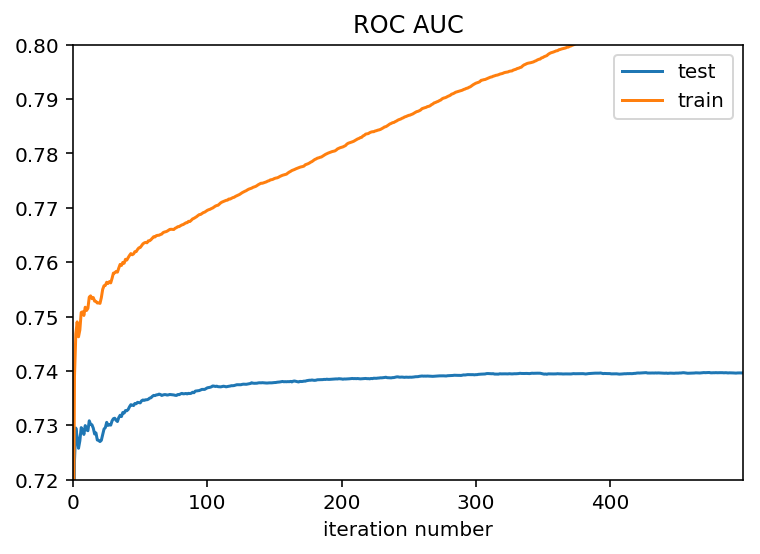

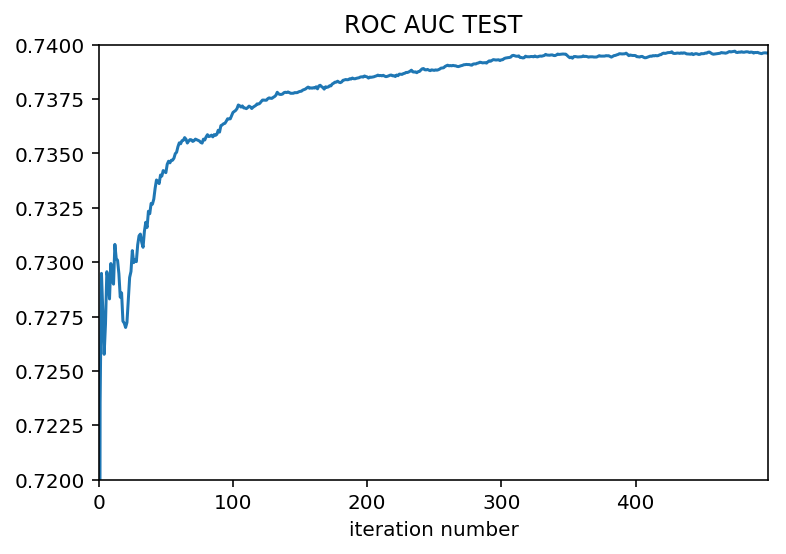

In [157]:
res = save_online_metric(clf_xgb)
res.plot(ylim=(0.72, 0.8), title='ROC AUC')
plt.xlabel('iteration number')
plt.figure()
res.test.plot(ylim=(0.72, 0.74), title='ROC AUC TEST')
plt.xlabel('iteration number')

### HyperOpt

http://hyperopt.github.io/hyperopt/

Инструмент для автоматической "умной" оптимизации большого числа гиперпараметров. Использует алгоритм Tree of Parzen Estimators

In [110]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

#функция, которую будем МИНИМИЗИРОВАТЬ
def score(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_jobs'] = -1
    print("Training with params : ", params)
    clf = xgb.XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred_xgb_test = clf.predict_proba(X_test)[:, 1]
    auc = calc_auc(y_test, y_pred_xgb_test, prin=False)
    result = {'loss': 1-auc, 'status': STATUS_OK}
    print('TEST ROC AUC: {0:.4f}'.format(auc))
    return result



space = {'max_depth' : hp.quniform('max_depth', 1, 10, 1),
         'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
         'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
         'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
         'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
         'silent' : 1,
         'n_estimators': 50,
         'learning_rate': 0.03
         }
trials = Trials()

best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=20)

Training with params :  {'gamma': 0.5, 'learning_rate': 0.03, 'n_jobs': -1, 'colsample_bytree': 0.9, 'subsample': 0.7000000000000001, 'max_depth': 9, 'min_child_weight': 6.0, 'n_estimators': 50, 'silent': 1}
TEST ROC AUC: 0.7341
Training with params :  {'gamma': 0.9, 'learning_rate': 0.03, 'n_jobs': -1, 'colsample_bytree': 0.8, 'subsample': 0.55, 'max_depth': 6, 'min_child_weight': 3.0, 'n_estimators': 50, 'silent': 1}
TEST ROC AUC: 0.7351
Training with params :  {'gamma': 1.0, 'learning_rate': 0.03, 'n_jobs': -1, 'colsample_bytree': 0.8, 'subsample': 0.9500000000000001, 'max_depth': 8, 'min_child_weight': 2.0, 'n_estimators': 50, 'silent': 1}
TEST ROC AUC: 0.7341
Training with params :  {'gamma': 0.9500000000000001, 'learning_rate': 0.03, 'n_jobs': -1, 'colsample_bytree': 0.55, 'subsample': 1.0, 'max_depth': 10, 'min_child_weight': 3.0, 'n_estimators': 50, 'silent': 1}
TEST ROC AUC: 0.7326
Training with params :  {'gamma': 0.8, 'learning_rate': 0.03, 'n_jobs': -1, 'colsample_bytree': 

In [119]:
best

{'colsample_bytree': 0.65,
 'gamma': 0.9500000000000001,
 'max_depth': 6.0,
 'min_child_weight': 9.0,
 'subsample': 0.65}

In [120]:
trials.best_trial

{'book_time': datetime.datetime(2018, 4, 26, 9, 44, 1, 900000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'colsample_bytree': [10],
   'gamma': [10],
   'max_depth': [10],
   'min_child_weight': [10],
   'subsample': [10]},
  'tid': 10,
  'vals': {'colsample_bytree': [0.65],
   'gamma': [0.9500000000000001],
   'max_depth': [6.0],
   'min_child_weight': [9.0],
   'subsample': [0.65]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2018, 4, 26, 9, 44, 12, 977000),
 'result': {'loss': 0.26235807789810095, 'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 10,
 'version': 0}

### Важность признаков

#### Встроенные методы

Нужно вытащить из sklearn обертки оригинальный объект класса xgboost.core.Booster

Есть 3 типа важности в get_score():

    weight - суммарное кол-во раз, когда признак использовался для разбиения вершины
    gain - средний прирост качества, когда признак использовался для разбиения вершины
    cover - среднее кол-во объектов, которые попадали в разбиение по признаку, когда он использовался для разбиения вершины

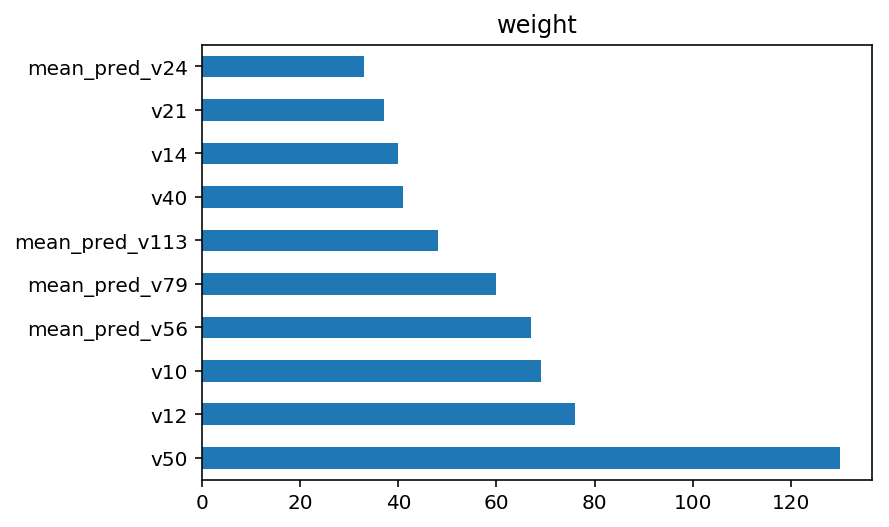

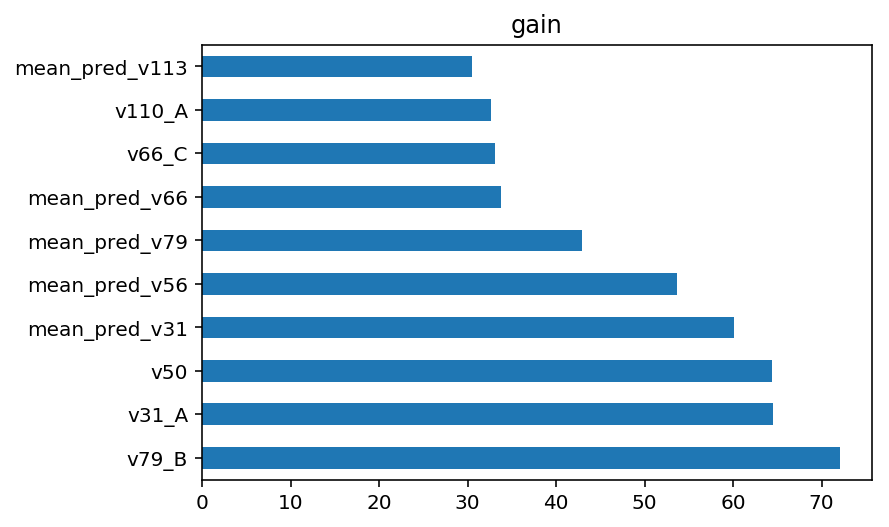

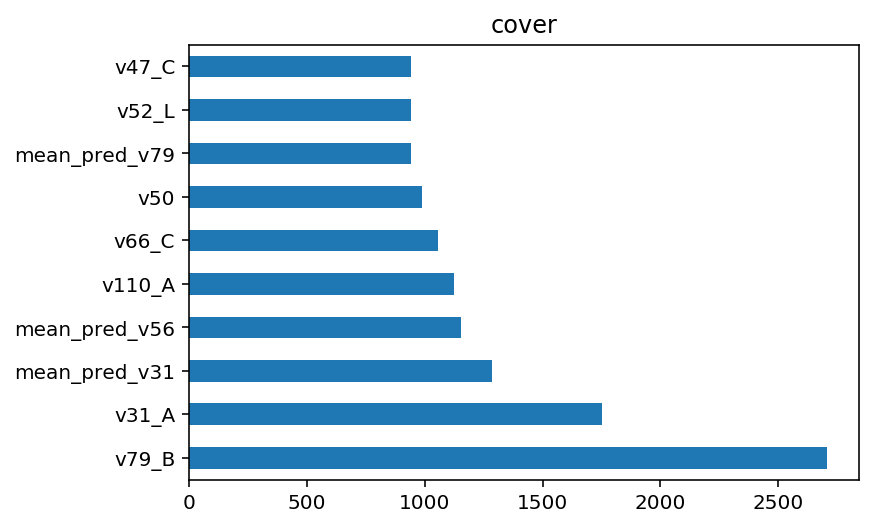

In [59]:
bst = clf_xgb.get_booster()

for kind in ['weight', 'gain', 'cover']:
    imp = pd.Series(bst.get_score(importance_type=kind))
    plt.figure()
    imp.sort_values(ascending=False).iloc[:10].plot(kind='barh', title=kind)

#### XGBFI

Позволяет оценивать важности взаимодействия признаков

https://github.com/limexp/xgbfir

In [61]:
import xgbfir
xgbfir.saveXgbFI(clf_xgb, OutputXlsxFile='xgbfi_report.xlsx')

In [86]:
pd.read_excel('xgbfi_report.xlsx', sheetname=0)

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,v50,8379.119607,130,45.142183,0.347248,64.454766,6730.150249,1,1,1,7,3,1,2.333333,27.446154,2.246154
1,mean_pred_v56,3598.714822,67,26.168327,0.390572,53.712162,2935.516102,2,4,2,5,5,2,3.333333,21.343284,2.179104
2,mean_pred_v79,2572.762650,60,18.799761,0.313329,42.879378,1889.785204,3,5,3,10,6,3,5.000000,18.683333,2.533333
3,mean_pred_v113,1465.084740,48,12.661560,0.263783,30.522599,669.946590,4,6,6,12,10,4,7.000000,25.333333,2.645833
4,v10,1435.705430,69,15.155029,0.219638,20.807325,443.936822,5,3,5,17,12,7,8.166667,21.869565,2.884058
5,v12,1275.031661,76,15.607611,0.205363,16.776732,425.925391,6,2,4,18,19,8,9.500000,24.105263,2.907895
6,v66_C,1093.207090,33,12.009676,0.363930,33.127488,545.686811,7,10,7,6,8,5,7.166667,24.121212,2.272727
7,mean_pred_v66,912.209483,27,6.240608,0.231134,33.785536,326.200499,8,16,8,14,7,9,10.333333,17.703704,2.740741
8,v66_B,759.393880,29,4.337341,0.149563,26.185996,143.388821,9,14,14,32,11,12,15.333333,26.310345,2.482759
9,mean_pred_v31,601.634320,10,4.327141,0.432714,60.163432,489.597919,10,24,15,3,4,6,10.333333,22.300000,1.800000


# Домашняя работа

#### Простая
1. Решаем ту же задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Используем **objective = "reg:linear"** в xgboost
5. Провести настройку гиперпараметров, используя либо hyperopt либо ручную настройку, как вам больше нравится
6. Использовать отложенную выборку (как на занятии), чтобы следить за процессом обучения xgboost'а, но, как и в предыдущем домашнем задании, финальную оценку качества давать используя 10-fold кросс-валидацию.
4. Проанализировать, насколько согласованы оценка на отложенной выборке и на кросс-валидации (одновременно уменьшаются/увеличиваются при изменении гиперпараметров или ведут себя по-разному)
5. Проанализировать признаки, используя XGBFI, сделать выводы об интересных взаимодействиях
7. В качестве решения:
    Jupyter notebook с кодом и комментариями